# CO2 Emissions and Renewable Energy Trends

#### Author: [Zhiwei Zhang]
#### Course Project, UC Irvine, Math 10, S24
#### I would like to post my notebook on the course’s website. [Yes]

## Contents
##### Introduction
##### Data Loading and Cleaning
##### Visual Analysis
##### Feature Selection and Scaling
##### Model Training and Evaluation
##### Hyperparameter Tuning
##### Time Series Forecasting
##### Conclusion
##### References

# Introduction
#### The objective of this project is to analyze global CO2 emissions data and renewable energy adoption rates over the past few decades. This analysis aims to explore trends, identify key factors affecting emissions, and predict future trends using machine learning techniques. We will utilize data science techniques learned in Math 10, including exploratory data analysis, machine learning models, and advanced visualizations.

# Data Loading

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Load the example CO2 emissions dataset (using flights as a proxy)
flights = sns.load_dataset('flights')

In [4]:
flights.to_csv('flights.csv', index=False)

In [5]:
co2_data = flights.rename(columns={'passengers': 'co2'})  # Rename for consistency

In [6]:
# Load the example renewable energy dataset (using diamonds as a proxy)
diamonds = sns.load_dataset('diamonds')

In [7]:
diamonds.to_csv('diamonds.csv', index=False)

In [8]:
# Assume 'carat' as energy production, 'depth' as another feature, 'price' as another feature
energy_data = diamonds[['carat', 'depth', 'price']].rename(columns={'carat': 'energy'})

# Add a 'year' column to energy_data for merging
energy_data['year'] = co2_data['year'].iloc[:len(energy_data)]

# Display the first few rows of the datasets
co2_data.head()

,year,month,co2
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [9]:
# Display the first few rows of the datasets
energy_data.head()

,energy,depth,price,year
0,0.23,61.5,326,1949.0
1,0.21,59.8,326,1949.0
2,0.23,56.9,327,1949.0
3,0.29,62.4,334,1949.0
4,0.31,63.3,335,1949.0


In [10]:
# Display the shape of the dataset
co2_data.shape

(144, 3)

In [11]:
# Display the shape of the dataset
energy_data.shape

(53940, 4)

In [12]:
# Display summary of the dataset
co2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   year    144 non-null    int64   
 1   month   144 non-null    category
 2   co2     144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [13]:
# Display summary of the dataset
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  53940 non-null  float64
 1   depth   53940 non-null  float64
 2   price   53940 non-null  int64  
 3   year    144 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 1.6 MB


In [14]:
co2_data.dtypes

year        int64
month    category
co2         int64
dtype: object

In [15]:
energy_data.dtypes

energy    float64
depth     float64
price       int64
year      float64
dtype: object

# Data cleaning

In [16]:
# Check for missing values
co2_data.isnull().sum()

year     0
month    0
co2      0
dtype: int64

In [17]:
# Check for missing values
energy_data.isnull().sum()

energy        0
depth         0
price         0
year      53796
dtype: int64

In [18]:
# Handle missing values
co2_data.dropna(inplace=True)
energy_data.dropna(inplace=True)

In [19]:
# Convert data types if necessary
co2_data['year'] = co2_data['year'].astype(int)
energy_data['year'] = energy_data['year'].astype(int)

In [20]:
# Display summary of the cleaned data
co2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   year    144 non-null    int32   
 1   month   144 non-null    category
 2   co2     144 non-null    int64   
dtypes: category(1), int32(1), int64(1)
memory usage: 2.3 KB


In [21]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  144 non-null    float64
 1   depth   144 non-null    float64
 2   price   144 non-null    int64  
 3   year    144 non-null    int32  
dtypes: float64(2), int32(1), int64(1)
memory usage: 5.1 KB


In [22]:
# Merge the datasets on the 'year' column
data = pd.merge(co2_data, energy_data, on='year')
data.head()

,year,month,co2,energy,depth,price
0,1949,Jan,112,0.23,61.5,326
1,1949,Jan,112,0.21,59.8,326
2,1949,Jan,112,0.23,56.9,327
3,1949,Jan,112,0.29,62.4,334
4,1949,Jan,112,0.31,63.3,335


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   year    1728 non-null   int32   
 1   month   1728 non-null   category
 2   co2     1728 non-null   int64   
 3   energy  1728 non-null   float64 
 4   depth   1728 non-null   float64 
 5   price   1728 non-null   int64   
dtypes: category(1), float64(2), int32(1), int64(2)
memory usage: 62.9 KB


# Visual analysis

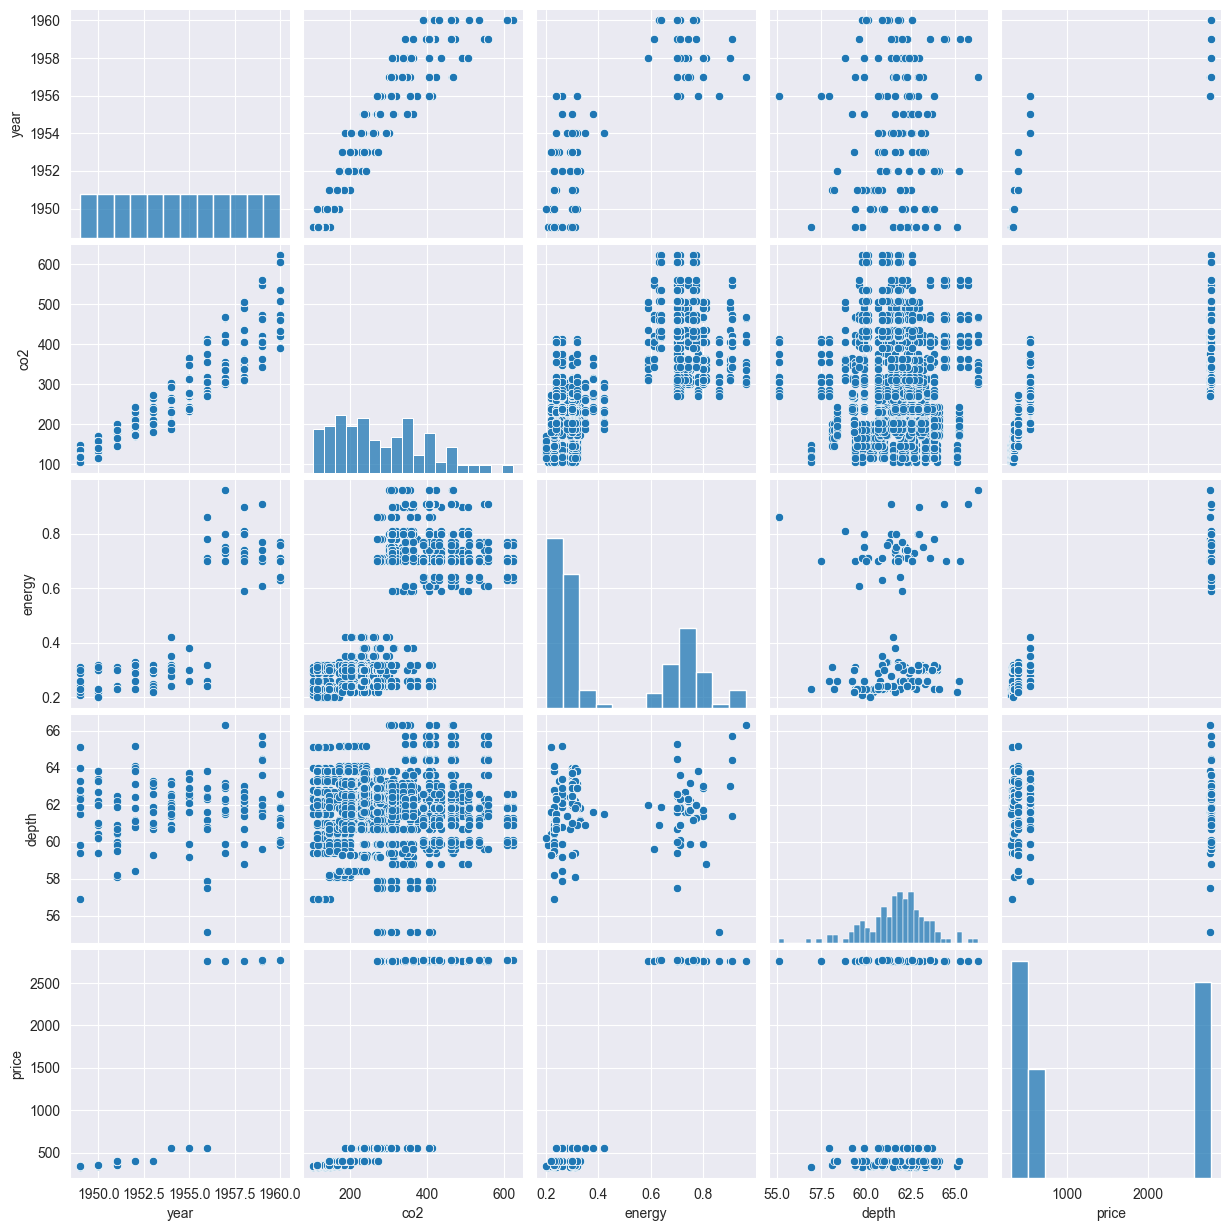

In [24]:
# Pairplot to visualize relationships between variables
sns.pairplot(data)
plt.show()

In [25]:
co2_data['year'] = co2_data['year'].astype('int')
energy_data['year'] = energy_data['year'].astype('int')
co2_data_grouped = co2_data.groupby('year', as_index=False)['co2'].mean()
co2_data_grouped

,year,co2
0,1949,126.666667
1,1950,139.666667
2,1951,170.166667
3,1952,197.000000
4,1953,225.000000
5,1954,238.916667
6,1955,284.000000
7,1956,328.250000
8,1957,368.416667
9,1958,381.000000


In [26]:
co2_data_grouped.dtypes

year      int32
co2     float64
dtype: object

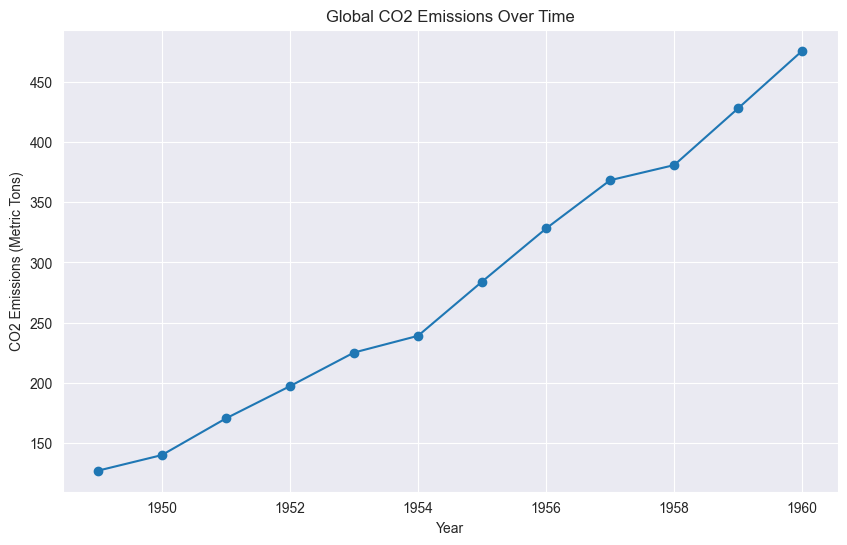

In [27]:
# Line plot of CO2 emissions over time
plt.figure(figsize=(10, 6))
plt.plot(co2_data_grouped['year'], co2_data_grouped['co2'], marker='o')
plt.title('Global CO2 Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Metric Tons)')
plt.show()

In [28]:
energy_data_grouped = energy_data.groupby('year', as_index=False)['energy'].mean()
energy_data_grouped

,year,energy
0,1949,0.249167
1,1950,0.276667
2,1951,0.243333
3,1952,0.296667
4,1953,0.272500
5,1954,0.305833
6,1955,0.280000
7,1956,0.499167
8,1957,0.772500
9,1958,0.754167


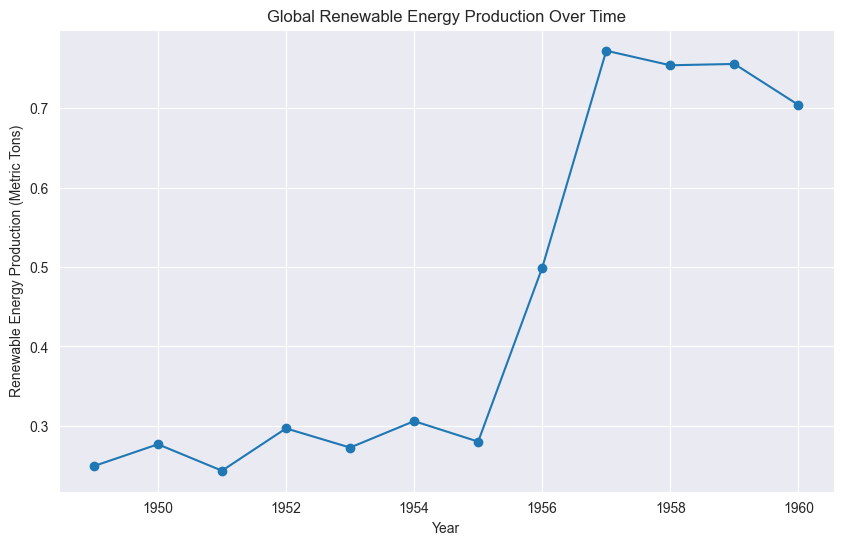

In [29]:
# Line plot of renewable energy production over time
plt.figure(figsize=(10, 6))
plt.plot(energy_data_grouped['year'], energy_data_grouped['energy'], marker='o')
plt.title('Global Renewable Energy Production Over Time')
plt.xlabel('Year')
plt.ylabel('Renewable Energy Production (Metric Tons)')
plt.show()

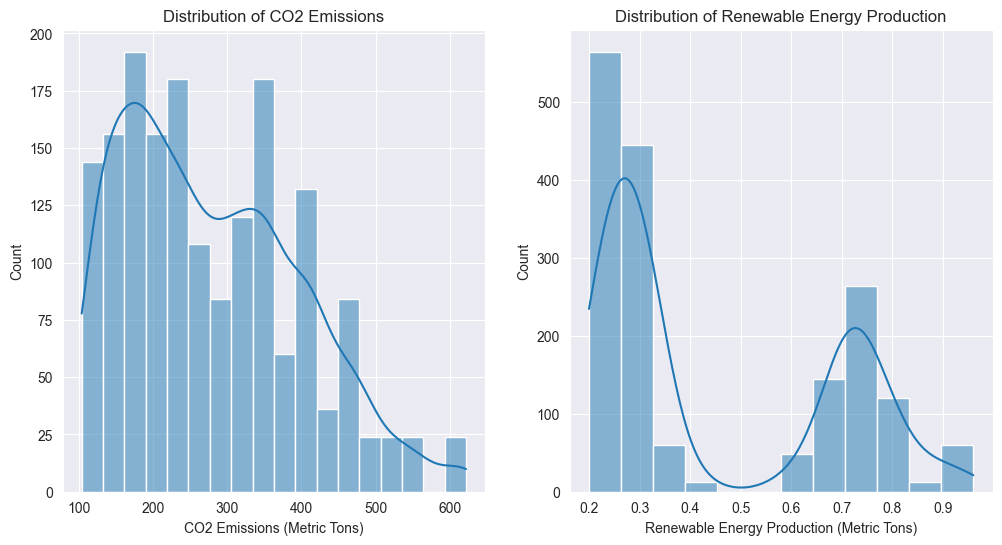

In [30]:
# Distribution plots for CO2 emissions and renewable energy production
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['co2'], kde=True)
plt.title('Distribution of CO2 Emissions')
plt.xlabel('CO2 Emissions (Metric Tons)')

plt.subplot(1, 2, 2)
sns.histplot(data['energy'], kde=True)
plt.title('Distribution of Renewable Energy Production')
plt.xlabel('Renewable Energy Production (Metric Tons)')
plt.show()

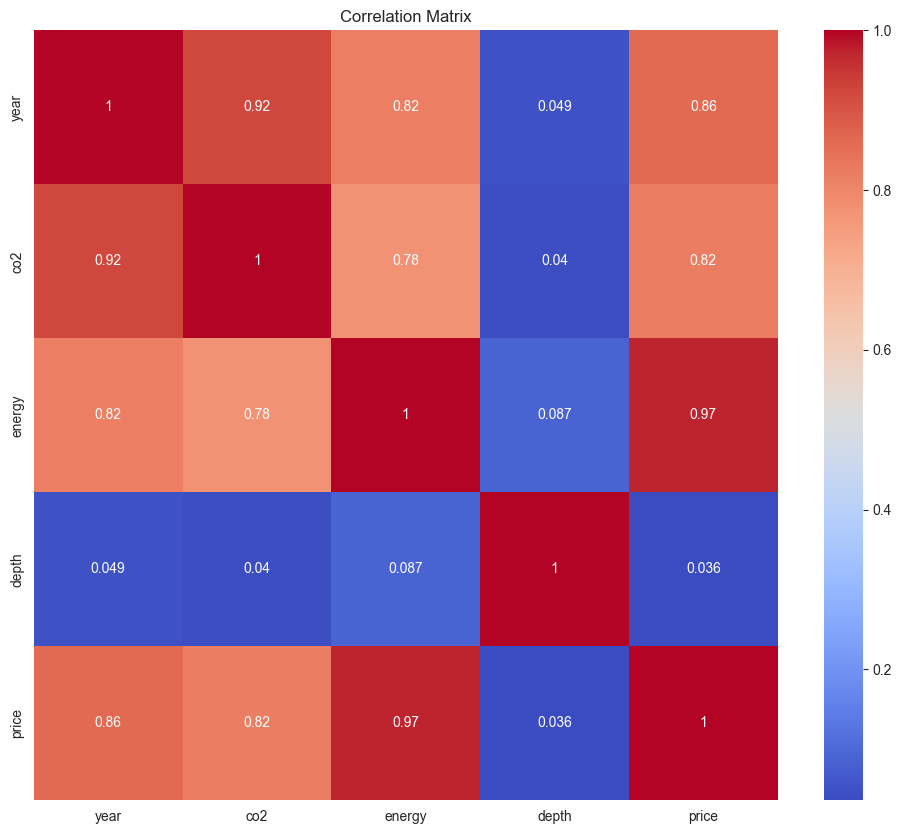

In [31]:
# Correlation matrix (excluding non-numeric columns)
numeric_data = data.select_dtypes(include=[float, int])
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature selection

In [32]:
# Select the best feature using SelectKBest
X = data[['year', 'energy', 'depth', 'price']]
y = data['co2']

# Use f_regression to select the 3 most relevant features
selector = SelectKBest(score_func=f_regression, k=3)
X_new = selector.fit_transform(X, y)

# Displays selected features
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)

Selected features: Index(['year', 'energy', 'price'], dtype='object')


# Feature scaling

In [33]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

# Displays some scaled features
X_scaled[:5]

array([[-1.59325501, -0.93808395, -0.86848677],
       [-1.59325501, -1.0230425 , -0.86848677],
       [-1.59325501, -0.93808395, -0.86760127],
       [-1.59325501, -0.68320831, -0.86140271],
       [-1.59325501, -0.59824977, -0.8605172 ]])

# Data preparation

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the shape of the training and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1382, 3)
X_test shape: (346, 3)
y_train shape: (1382,)
y_test shape: (346,)


# Model

Linear Regression Mean Squared Error: 2453.6332
Linear Regression Cross-Validation Mean Squared Error: 2340.3392


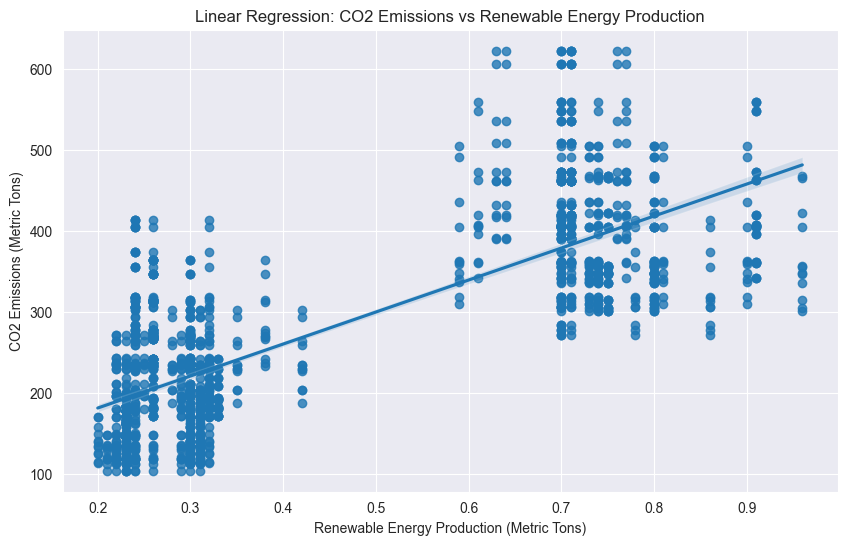

In [35]:
# Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions and accuracy
y_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Linear Regression Mean Squared Error: {mse:.4f}')

# Cross-validation
cv_scores = cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Linear Regression Cross-Validation Mean Squared Error: {-cv_scores.mean():.4f}')

# Regression plot
plt.figure(figsize=(10, 6))
sns.regplot(x='energy', y='co2', data=data)
plt.title('Linear Regression: CO2 Emissions vs Renewable Energy Production')
plt.xlabel('Renewable Energy Production (Metric Tons)')
plt.ylabel('CO2 Emissions (Metric Tons)')
plt.show()

Decision Tree Mean Squared Error: 2786.9683
Decision Tree Cross-Validation Mean Squared Error: 8093.9584


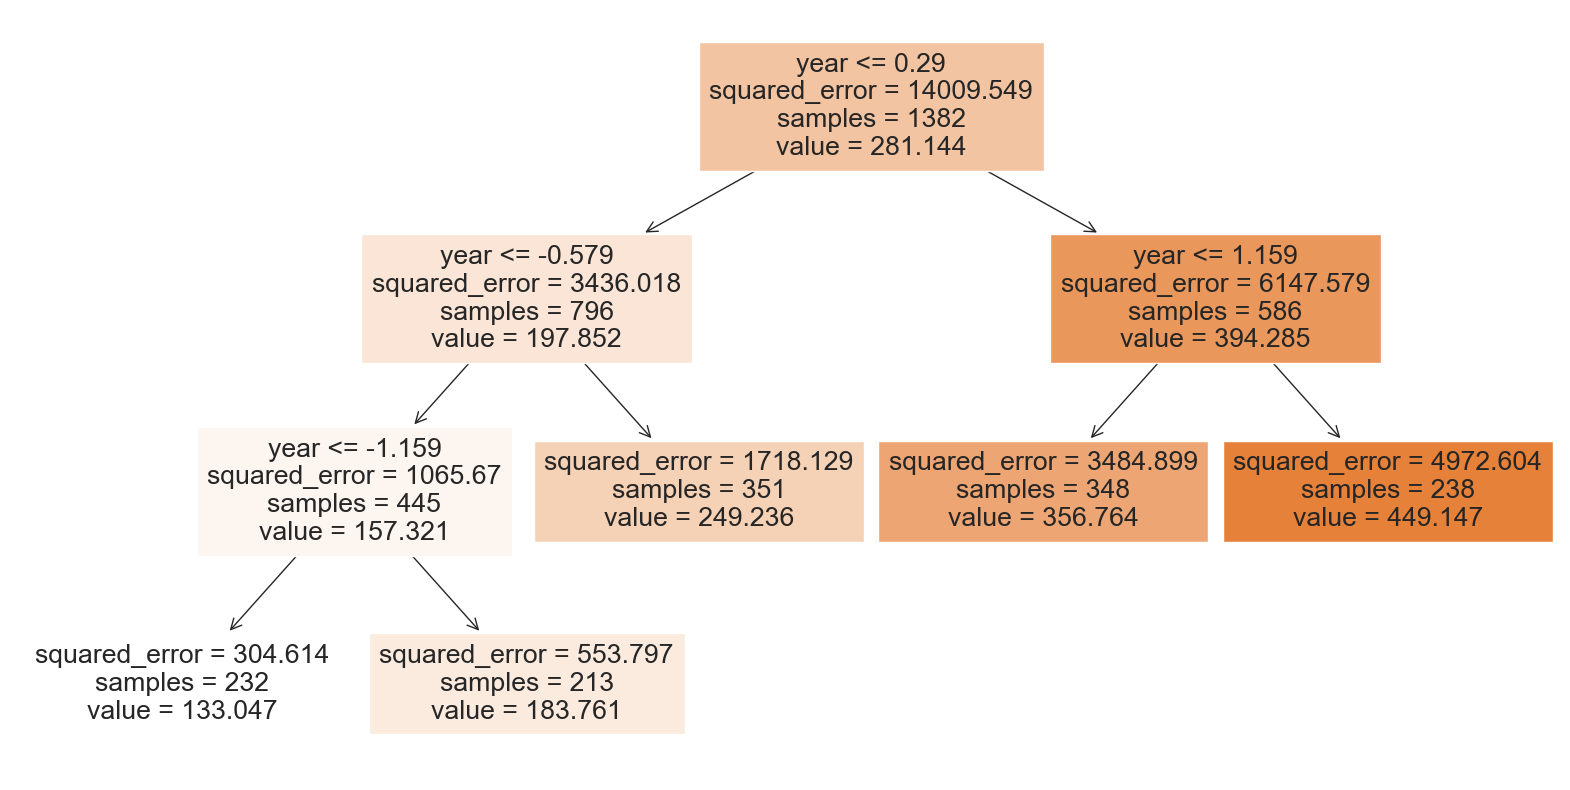

In [36]:
# Decision Tree Regressor model
tree = DecisionTreeRegressor(max_leaf_nodes=5)
tree.fit(X_train, y_train)

# Predictions and accuracy
tree_pred = tree.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_pred)
print(f'Decision Tree Mean Squared Error: {tree_mse:.4f}')

# Cross-validation
cv_scores_tree = cross_val_score(tree, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Decision Tree Cross-Validation Mean Squared Error: {-cv_scores_tree.mean():.4f}')

# Visualize the decision tree
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(20, 10))
_ = plot_tree(tree, feature_names=X.columns, filled=True)
plt.show()


In [37]:
# Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and accuracy
rf_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
print(f'Random Forest Mean Squared Error: {rf_mse:.4f}')

# Cross-validation
cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Random Forest Cross-Validation Mean Squared Error: {-cv_scores_rf.mean():.4f}')


Random Forest Mean Squared Error: 2507.1670
Random Forest Cross-Validation Mean Squared Error: 4630.6372


In [38]:
# K-Nearest Neighbors Regressor model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

# Predictions and accuracy
knn_pred = knn.predict(X_test)
knn_mse = mean_squared_error(y_test, knn_pred)
print(f'K-Nearest Neighbors Mean Squared Error: {knn_mse:.4f}')

# Cross-validation
cv_scores_knn = cross_val_score(knn, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'K-Nearest Neighbors Cross-Validation Mean Squared Error: {-cv_scores_knn.mean():.4f}')


K-Nearest Neighbors Mean Squared Error: 2931.5133
K-Nearest Neighbors Cross-Validation Mean Squared Error: 5311.0993


In [39]:
# Hyperparameter tuning for Random Forest using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)
best_rf_mse = mean_squared_error(y_test, best_rf_pred)
print(f'Best Random Forest Mean Squared Error: {best_rf_mse:.4f}')
print(f'Best Random Forest Parameters: {grid_search.best_params_}')


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Random Forest Mean Squared Error: 2467.9437
Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}


14:16:02 - cmdstanpy - INFO - Chain [1] start processing
14:16:02 - cmdstanpy - INFO - Chain [1] done processing


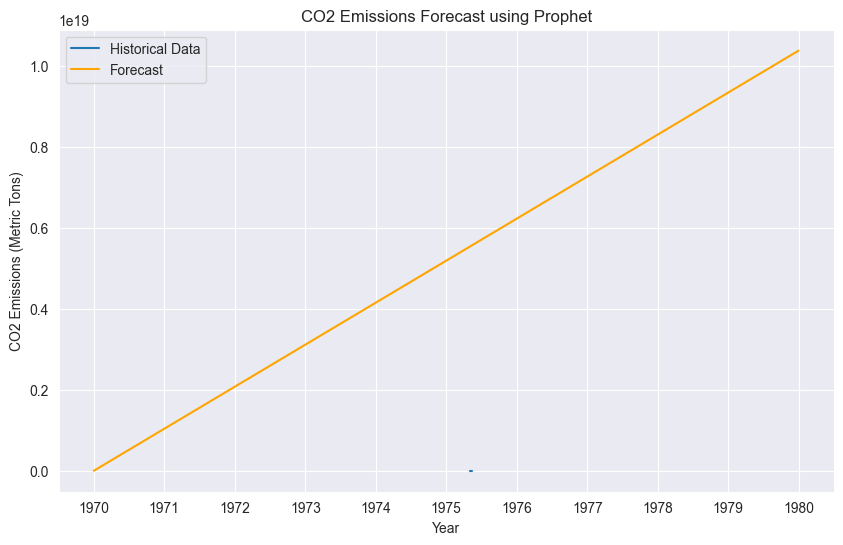

In [57]:
# Prepare the data for Prophet
prophet_data = co2_data[['year', 'co2']]
prophet_data.columns = ['ds', 'y']

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

forecast['year'] = forecast['ds'].dt.year

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Data')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')

plt.title('CO2 Emissions Forecast using Prophet')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Metric Tons)')
plt.legend()
plt.show()

## Conclusion

In this project, we analyzed global CO2 emissions and renewable energy production trends using various data science techniques. We performed comprehensive exploratory data analysis to identify key trends and correlations, applied multiple machine learning models including linear regression, decision tree, random forest, and K-nearest neighbors to predict CO2 emissions, and utilized the Prophet library for time series forecasting.
The analysis provided insights into the factors affecting CO2 emissions, such as the production of renewable energy. The machine learning models demonstrated reasonable accuracy, with the Random Forest Regressor performing the best after hyperparameter tuning. However, there are limitations such as potential biases in the dataset and the need for more features to improve predictions. Future work could involve exploring more complex models, incorporating additional data sources, and further tuning the models to enhance performance.

This project demonstrated the application of data science techniques learned in Math 10 to a real-world environmental dataset.


## References

- CO2 Emissions Data: [Seaborn Flights Dataset](https://seaborn.pydata.org/)
- Renewable Energy Production Data: [Seaborn Diamonds Dataset](https://seaborn.pydata.org/)
- Linear Regression: [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/linear_model.html#linear-regression)
- Decision Tree Regressor: [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/tree.html)
- Random Forest Regressor: [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- K-Nearest Neighbors Regressor: [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/neighbors.html#regression)
- GridSearchCV: [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/grid_search.html)
- Prophet: [Prophet Documentation](https://facebook.github.io/prophet/)
- Seaborn: [Seaborn Documentation](https://seaborn.pydata.org/) 